Notebook uses BedMachine Antarctica ice-surface and bed topographies to calculate and export subglacial hydropotential using the Shreve (1972) hydropotential equation.

Written 2025/07/20 by W. Sauthoff (wsauthoff.github.io) and M. R. Siegfried (mrsiegfried.github.io).

# Setup computing environment

In [1]:
# Import packages
import earthaccess
import fsspec
import json
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
from pyproj import CRS
import shutil
import xarray as xr
import zarr
import zipfile

os.makedirs('output', exist_ok = True)

%matplotlib widget

# Access data

In [2]:
# Direct-access stream BedMachine Antarctica bed and surface topography v3 (Morlighem et al., 2020; Morlighem, 2022)
# https://nsidc.org/data/NSIDC-0756
try:
    results = earthaccess.search_data(
        doi='10.5067/FPSU0V1MWUB6',
        cloud_hosted=True,
        # bounding_box=(1, -89, -1, -89)
    )
    
    if not results:
        raise ValueError('No datasets found matching the search criteria')
        
    # Open data granules as s3 files to stream
    files = earthaccess.open(results)
    
    # Check if files list is empty
    if not files:
        raise FileNotFoundError('No files were opened from the search results')
        
    # Check if first file exists/is valid
    if isinstance(files[0], FileNotFoundError):
        raise FileNotFoundError(f'Could not access file: {files[0]}')
        
    # Print file name to ensure expected dataset
    print(f'Attempting to open: {files[0]}')
    
    # Open file into xarray dataset
    bedmachine_original = xr.open_dataset(files[0], engine='h5netcdf')
    print('Dataset successfully loaded')

except FileNotFoundError as e:
    print(f'File access error: {e}')
except ValueError as e:
    print(f'Search error: {e}')
except Exception as e:
    print(f'Unexpected error: {e}')

'''
Note: "Search error: can only read bytes or file-like objects with engine='scipy' or 'h5netcdf'" seems to indicate a FileNotFoundError,
signaling a problem at the data center.
'''

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Attempting to open: <File-like object S3FileSystem, nsidc-cumulus-prod-protected/MEASURES/NSIDC-0756/3/1970/01/01/BedMachineAntarctica-v3.nc>
Dataset successfully loaded


'\nNote: "Search error: can only read bytes or file-like objects with engine=\'scipy\' or \'h5netcdf\'" seems to indicate a FileNotFoundError,\nsignaling a problem at the data center.\n'

In [8]:
# View dataset
bedmachine_original

<xarray.Dataset> Size: 4GB
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y          (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000
Data variables:
    mapping    |S1 1B ...
    mask       (y, x) int8 178MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    firn       (y, x) float32 711MB ...
    surface    (y, x) float32 711MB ...
    thickness  (y, x) float32 711MB ...
    bed        (y, x) float32 711MB -5.916e+03 -5.92e+03 ... -3.664e+03
    errbed     (y, x) float32 711MB ...
    source     (y, x) int8 178MB ...
    dataid     (y, x) int8 178MB ...
    geoid      (y, x) int16 356MB ...
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [3]:
# # Open local copy of file if streaming fails
# bedmachine_original = xr.open_dataset('/home/jovyan/temp/BedMachineAntarctica-v3.nc')
# bedmachine_original

# Generate hydropotential dataset
Use Shreve (1972) equation to calculate hydropotential using bed elevations and ice-surface elevations (less firn depth to get ice mass):

**θₕ** = g ⋅ [(ρ<sub>water</sub> − ρ<sub>ice</sub>) ⋅ z<sub>bed</sub> + (ρ<sub>ice</sub> ⋅ z<sub>surface</sub>)]  

See README for more information.

In [4]:
# Step 1: Compute hydropotential

# Use BedMachine bed topography for bed height (Zbed) and surface topography (less firn) for ice surface height (Zsurf)

# Define densities (rho) of ice and water
rho_ice = 917
rho_water = 997

# Calculate hydropotential using Shreve, 1972 equation
# subglacial_hydropotential_kPa = (9.8 * ((rho_ice*(bedmachine_original['surface']-bedmachine_original['firn'])) + (rho_water-rho_ice)*bedmachine_original['bed'])) / 1e3
subglacial_hydropotential_ds = 9.8 * ((rho_water-rho_ice)*bedmachine_original['bed'] + rho_ice*(bedmachine_original['surface']-bedmachine_original['firn']))

# Display xarray.Dataset metadata
subglacial_hydropotential_ds

<xarray.DataArray (y: 13333, x: 13333)> Size: 711MB
array([[-4637787. , -4641434.5, -4645678. , ..., -3103351.2, -3108075. ,
        -3112880.8],
       [-4634423. , -4638674.5, -4642923. , ..., -3107068.5, -3111754. ,
        -3111487.8],
       [-4631323.5, -4635563. , -4639981.5, ..., -3113233.8, -3115269.8,
        -3114826. ],
       ...,
       [-3593728. , -3580337.5, -3573411.5, ..., -2873387. , -2873878.2,
        -2873621. ],
       [-3605889.2, -3593214.2, -3597311.8, ..., -2871748.5, -2873867.2,
        -2873666. ],
       [-3626012. , -3618005. , -3621984.5, ..., -2870198. , -2872369. ,
        -2872873.8]], dtype=float32)
Coordinates:
  * x        (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y        (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000

In [5]:
# Step 2: Mask to grounded ice only

# Create a mask where values == 2 (grounded ice)
grounded_ice_mask = (bedmachine_original['mask'] == 2)

# Apply the mask to subglacial_hydropotential_ds
subglacial_hydropotential_ds = subglacial_hydropotential_ds.where(grounded_ice_mask)

# Display xarray.Dataset metadata to ensure edges have become nan's
subglacial_hydropotential_ds

<xarray.DataArray (y: 13333, x: 13333)> Size: 711MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) int32 53kB -3333000 -3332500 -3332000 ... 3332500 3333000
  * y        (y) int32 53kB 3333000 3332500 3332000 ... -3332500 -3333000

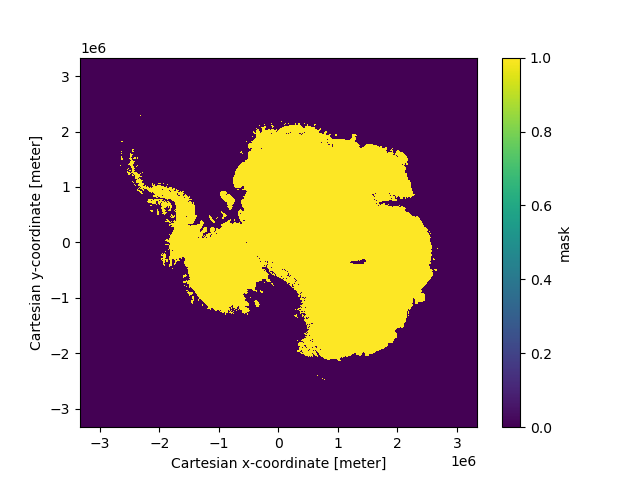

In [7]:
grounded_ice_mask.plot()

In [ ]:
# Example: da is a boolean DataArray with coordinates 'x' and 'y'
true_mask = grounded_ice_mask.where(grounded_ice_mask, drop=True)

x_min = float(true_mask['x'].min())
x_max = float(true_mask['x'].max())
y_min = float(true_mask['y'].min())
y_max = float(true_mask['y'].max())

print(x_min, x_max, y_min, y_max)
# # Set the data extent
# x_min, x_max, y_min, y_max = -2.85e6, 2.85e6, -2.75e6, 2.75e6

# Plot results and save figure
fig, ax = plt.subplots(figsize=(10, 8))

# Use actual data range for asymmetric colorbar
data_min = float(subglacial_hydropotential_ds.min())
data_max = float(subglacial_hydropotential_ds.max())

# # Display as MPa instead of Pa
# norm = mcolors.Normalize(vmin=data_min/1e6, vmax=data_max/1e6)
norm = mcolors.Normalize(vmin=data_min, vmax=data_max)

# Create the plot
im = subglacial_hydropotential_ds.plot(
    ax=ax, 
    add_colorbar=False,
    cmap='viridis',
    vmin=data_min,
    vmax=data_max,
    norm=norm
)

# Set the axis limits to clip to data extent + buffer
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Format axes
ax.set_aspect('equal')
# ax.set_axis_off()

# Create colorbar axes with same width as plot
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=-0.1)

# Add colorbar with label
cbar = plt.colorbar(im, cax=cax)#, orientation='horizontal')


# Compute tick values in Pa
# ticks_Pa = cbar.get_ticks()
ticks_Pa = np.linspace(data_min, data_max, 6)  # 6 evenly spaced ticks

# Convert them to MPa for labeling
tick_labels_MPa = [f"{tick/1e6:.0f}" for tick in ticks_Pa]

# Set tick positions and labels
cbar.set_ticks(ticks_Pa)
cbar.set_ticklabels(tick_labels_MPa)


# cbar.set_ticklabels([f"{tick/1e6:.0f}" for tick in cbar.get_ticks()])
cbar.set_label('subglacial hydropotential [MPa]')
# cbar.ax.tick_params()#labelrotation=45)

plt.tight_layout()
plt.show()

# plt.savefig('output/subglacial_hydropotential_Antarctica.png', bbox_inches='tight')

# Export dataset

In [ ]:
# Prepare dataset for export

# Add variable metadata
subglacial_hydropotential_ds.attrs = {
    'units': 'Pa',
    'ice_density' : 917.0,
    'ice_density_units': 'kg m-3',
    'freshwater_density' : 997.0,
    'freshwater_density_units': 'kg m-3',
}

# Convert to dataset for chucking with Zarr
ds = subglacial_hydropotential_ds.to_dataset(name='subglacial_hydropotential')

# Add global metadata
ds.attrs = {
    'conventions': 'CF-1.8',
    'title': 'Antarctic subglacial hydropotential derived from BedMachine Antarctica',
    'description': 'Antarctic subglacial gridded hydropotential calculated using Shreve (1972) equation using BedMachine Antarctica v3 bed and ice topographies and firn air content (Morlighem et al., 2020; Morlighem, 2022).',
    'history': 'Created 2025-07-20',
    'identifier_product_DOI': 'doi:10.5281/zenodo.16243278',
    'citation': 'Sauthoff, W. & Siegfried, M. R. (2025). Antarctic subglacial hydropotential [Data set]. Zenodo. https://doi.org/10.5281/zenodo.16243278',
    'license': 'CC BY-SA 4.0',
    'region': 'Antarctica'
}

# Copy mapping variable into new dataset as variable with zero dimensions
mapping_attrs = bedmachine_original['mapping'].attrs
ds['mapping'] = xr.DataArray(np.array(0, dtype=np.int32), attrs=mapping_attrs)

# Link the mapping variable to hydropotential variable
ds['subglacial_hydropotential'].attrs['grid_mapping'] = 'mapping'

# Copy global CRS-related attributes
ds.attrs['proj4'] = bedmachine_original.attrs['proj4']
ds.attrs['Projection'] = bedmachine_original.attrs['Projection']

# Add crs and crs_wkt
ds.attrs['crs'] = 'EPSG:3031'
crs = CRS.from_epsg(3031)
ds.attrs['crs_wkt'] = crs.to_wkt()

# View ds metadata
ds

## Export to chucked netcdf

In [ ]:
# Export with chunking + compression
ds.to_netcdf(
    'output/subglacial_hydropotential_Antarctica.nc',
    encoding={
        'subglacial_hydropotential': {
            'dtype': 'float32',
            'zlib': True,
            'complevel': 4,
            'chunksizes': (500, 500)
        }
    }
)

## Validate dataset after export
First check climate and forecast conventions, then importing exported file, viewing metadata and plotting data.

In [ ]:
!conda install -c conda-forge cfchecker --quiet

In [ ]:
!cfchecks output/subglacial_hydropotential_Antarctica.nc

In [ ]:
ds_imported = xr.open_dataset('output/subglacial_hydropotential_Antarctica.nc')
ds_imported

In [ ]:
ds_imported.info()

In [ ]:
# Check that NaN values are preserved
print('Original NaN count:', ds['subglacial_hydropotential'].isnull().sum())
print('Imported NaN count:', ds_imported['subglacial_hydropotential'].isnull().sum())

In [ ]:
plt.figure()
ds_imported['subglacial_hydropotential'].plot()
plt.show()

In [ ]:
# Opened netcdf in Panoply to ensure compatibility

## Export to Zarr

In [ ]:
# Chunk for performance (tune based on size and use case)
ds = ds.chunk({'x': 500, 'y': 500})

# Write to a Zarr store
ds.to_zarr('output/subglacial_hydropotential_Antarctica.zarr', mode='w',  consolidated=True)

In [ ]:
# Zip zarr files for upload to Zenodo
shutil.make_archive(
    'output/subglacial_hydropotential_Antarctica.zarr',  # output path (no zip extension)
    'zip',
    'output/subglacial_hydropotential_Antarctica.zarr'   # source
)

In [ ]:
!rm -r 'output/subglacial_hydropotential_Antarctica.zarr'

## Validate dataset after export
Unzip zip file of Zarr store, then import data, view metadata, plot data.

In [ ]:
# Extract the zip file
with zipfile.ZipFile('output/subglacial_hydropotential_Antarctica.zarr.zip', 'r') as zip_ref:
    zip_ref.extractall('output/subglacial_hydropotential_Antarctica.zarr')

# Now open normally
ds_imported = xr.open_zarr('output/subglacial_hydropotential_Antarctica.zarr', consolidated=True)
ds_imported

In [ ]:
ds_imported.info()

In [ ]:
# Check that NaN values are preserved
print('Original NaN count:', ds['subglacial_hydropotential'].isnull().sum().compute())
print('Imported NaN count:', ds_imported['subglacial_hydropotential'].isnull().sum().compute())

In [ ]:
plt.figure()
ds_imported['subglacial_hydropotential'].plot()
plt.show()

In [ ]:
# Remove Zarr store folder
!rm -r 'output/subglacial_hydropotential_Antarctica.zarr'

# Remove temporary files
Files are first downloaded locally to upload to Zenodo repo.

In [ ]:
!rm 'output/subglacial_hydropotential_Antarctica.nc'

In [ ]:
!rm 'output/subglacial_hydropotential_Antarctica.zarr.zip'

# References

Morlighem, M., Rignot, E., Binder, T., Blankenship, D., Drews, R., Eagles, G., et al. (2020). Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet. _Nature Geoscience_, 13(2), 132–137. https://doi.org/10.1038/s41561-019-0510-8

Morlighem, M. (2022). MEaSUREs BedMachine Antarctica. (NSIDC-0756, Version 3). [Data Set]. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. https://doi.org/10.5067/FPSU0V1MWUB6. Date Accessed 05-19-2025.

Sauthoff, W., & Siegfried, M. R. (2025). Antarctic subglacial hydropotential [Data set]. Zenodo. [doi:10.5281/zenodo.16323063](https://doi.org/10.5281/zenodo.16323063)

Shreve, R. L. (1972). Movement of Water in Glaciers. _Journal of Glaciology_, 11(62), 205–214. https://doi.org/10.3189/S002214300002219X